In [2]:
# 引入库
from typing import Dict, List

import empyrical as ep
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from data_service import get_index_daily, get_sales_depart_billboard
from scr import HMA, calc_netbuy, get_exchange_set
from scr.bt_func import analysis_rets, analysis_trade, get_backtesting, netbuy_cross
from scr.plotting import plot_distribution, plot_indicator, plot_qunatile_signal
from scr.tushare_api import TuShare

my_ts = TuShare()

# 数据准备

In [4]:
# 数据获取
billboard_df: pd.DataFrame = get_sales_depart_billboard(
    '2013-01-01', '2022-07-11')

# 数据储存
billboard_df.to_csv('../data/billboard.csv', encoding='utf-8')

In [5]:
# 读取本地文件
billboard_df: pd.DataFrame = pd.read_csv('../data/billboard.csv',
                                         encoding='utf-8',
                                         index_col=[0],
                                         parse_dates=['trade_date'])

In [6]:
# 获取沪深300数据
hs300: pd.DataFrame = get_index_daily(code='000300.SH',
                                      start_date='20130101',
                                      end_date='20220711')
hs300.set_index('trade_date', inplace=True)


In [7]:
# 查看数据结构
hs300.head()

,code,close,open,high,low,pre_close,change,pct_chg,vol,amount
trade_date,,,,,,,,,,
2013-01-04,000300.SH,2524.409,2551.814,2558.529,2498.892,2522.952,1.457,0.0577,97988182.0,9.557925e+07
2013-01-07,000300.SH,2535.985,2518.047,2545.969,2511.603,2524.409,11.576,0.4586,75167993.0,7.316751e+07
2013-01-08,000300.SH,2525.330,2534.647,2540.513,2502.490,2535.985,-10.655,-0.4202,71837100.0,7.649806e+07
2013-01-09,000300.SH,2526.126,2518.104,2534.239,2504.299,2525.330,0.796,0.0315,70231170.0,7.423360e+07
2013-01-10,000300.SH,2530.569,2525.590,2553.352,2513.729,2526.126,4.443,0.1759,71085862.0,7.115905e+07


In [8]:
# 查看数据结构
billboard_df.head()

,trade_date,code,exalter,buy,buy_rate,sell,sell_rate,net_buy,side,reason
0,2013-01-04,000043.SZ,中国国际金融有限公司上海淮海中路证券营业部,16970815.06,1.19,16377628.0,1.24,-593187.06,0,连续三个交易日内，涨幅偏离值累计达20%的证券
264,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,1,换手率达20%的证券
263,2013-01-04,300262.SZ,光大证券股份有限公司深圳金田路证券营业部,17202495.10,2.03,5832845.6,5.98,-11369649.50,0,换手率达20%的证券
262,2013-01-04,300262.SZ,中国银河证券股份有限公司厦门美湖路证券营业部,7913689.96,0.01,26770.0,2.75,-7886919.96,1,换手率达20%的证券
261,2013-01-04,300262.SZ,中信证券股份有限公司上海淮海中路证券营业部,4772872.77,1.53,4398000.0,1.66,-374872.77,0,换手率达20%的证券


# 信号构造

1. 取得2013年1月4日至2022年2月22日之间沪深两市龙虎榜的数据,选取其中上榜席位为机构席位的信息,并计算当日所有单个席位净流入金额(单个席位买入金额-单个席位卖出金额)的总和,记为全市场机构席位绝对净流入额**IS_NetBuy**;
2. 为了使不同交易日之间的IS_NetBuy可比,在本文对IS_NetBuy做了两市成交额中性化处理即**IS_NetBuy/沪深300指数当日成交金额**，得到全市场机构席位净流入强度**IS_NetBuy_S**,即相对净流入;
3. IS_NetBuy_S就是我们需要分析的择时因子,我们希望能得到可能存在的非线性关系,我们进而绘制出IS_NetBuy_S的期望收益分布图，即计算每日IS_NetBuy_S数据对应的后10日沪深300指数涨跌幅情况,对所得结果按照 **IS_NetBuy_S**从小到大进行排序

## 席位分析期望收益分布

In [9]:
# 席位划分
exchange_set: Dict = get_exchange_set(billboard_df)

可以看到**机构席位**(图二):当相对净流入指标处于极值两端的时候,市场的未来期望收益率更高,即龙虎榜机构席位出现较大净流出或净流入后,后10日的沪深300指数对应为表现较好，而龙虎榜机构席位的净流入或净流出绝对值较低时，后10日的沪深300指数对应为表现较差。统计结果印证了机构龙虎榜影响下的有限注意力规律，即当机构席 位出现极端行为时很多的决策注意力被吸引而来，出现了较为明显的非线性交易规律， 整体的收益分布呈现出明显的V字型，即正收益来自于两端，负收益来自于中间。如果 择时因子与宽基未来收益显著正相关，且相关系数是 1，那么期望收益分布图则是一个 单调递增的形状。因此，期望收益分布图简单明了的表示择时因子与未来收益的非线性关系，而 IS_NetBuy_S 指标的期望收益分布图就是呈现出V型的非线性关系。

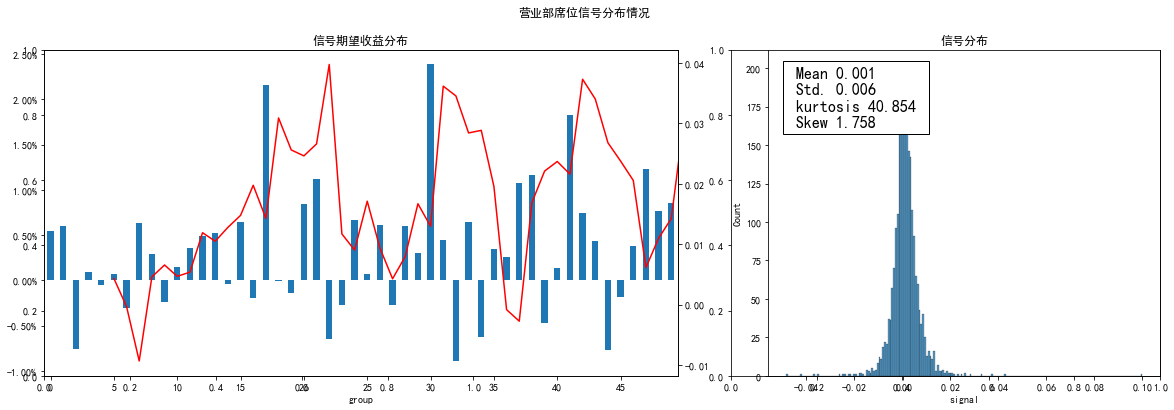

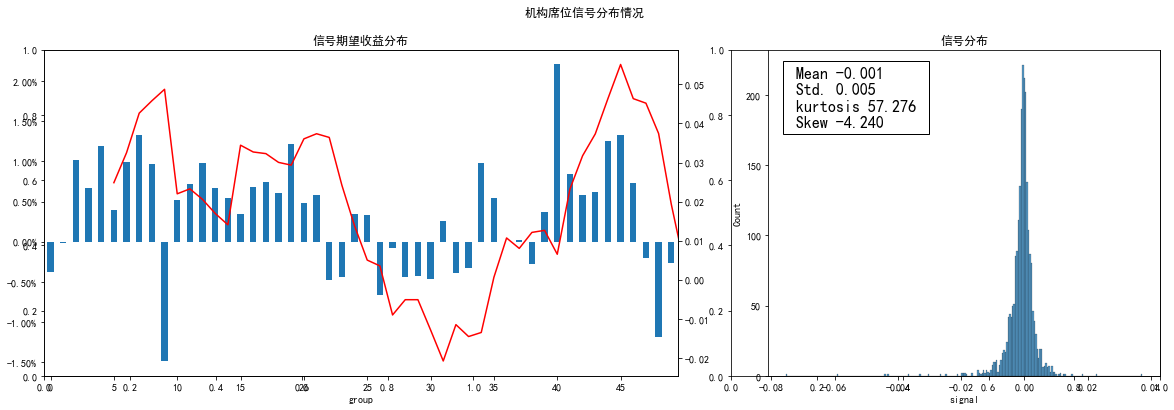

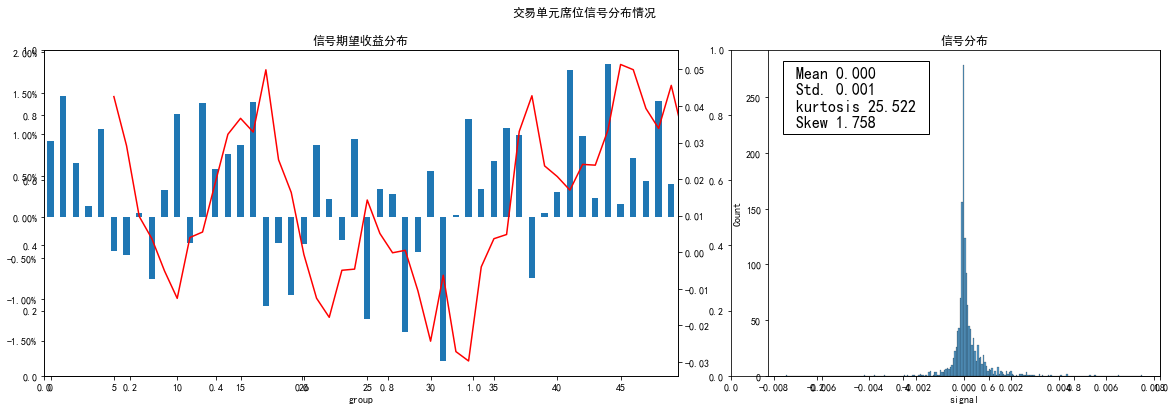

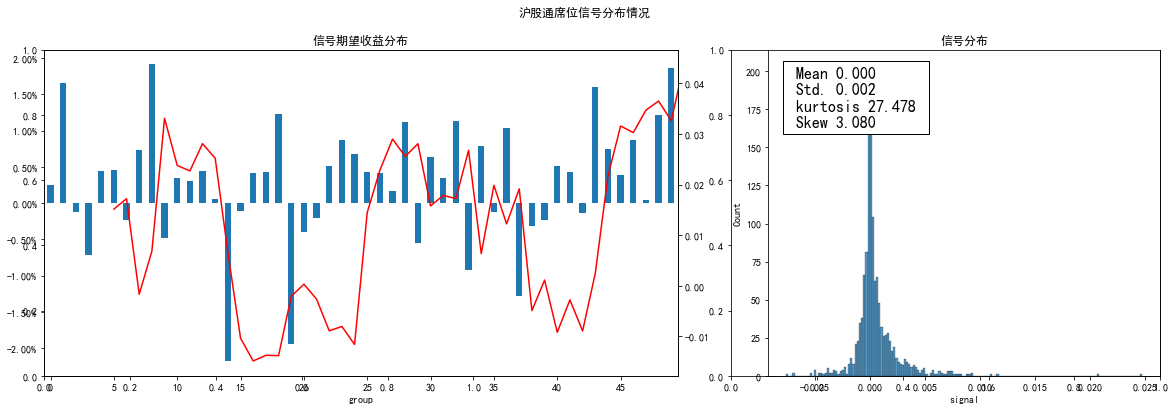

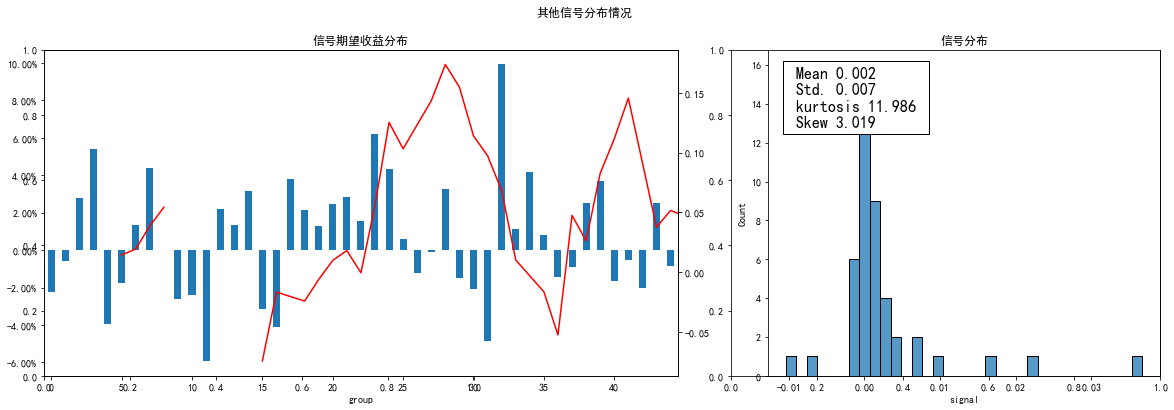

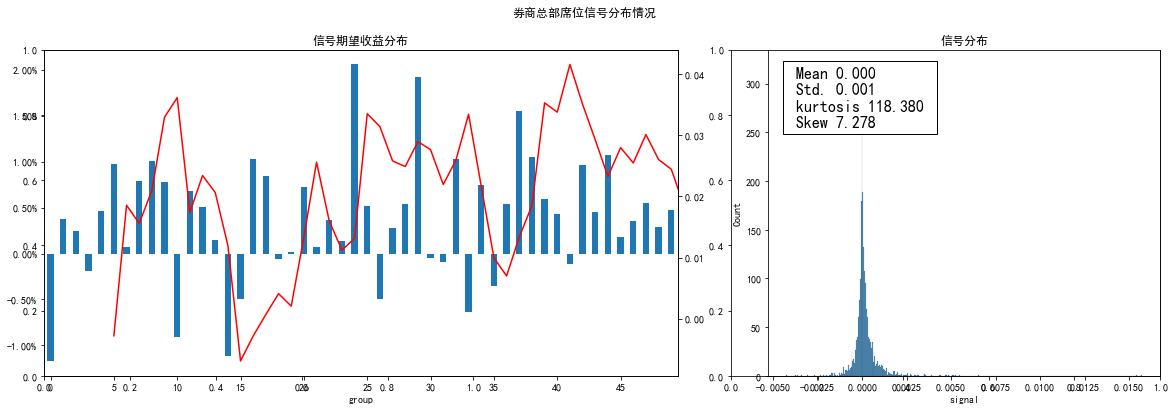

In [10]:
# 画分布
size: int = len(exchange_set)

for name, cond in exchange_set.items():

    is_netbuy_s: pd.Series = calc_netbuy(billboard_df[cond], hs300['amount'])
    plot_distribution(is_netbuy_s, hs300['close'], 10, f'{name}信号分布情况')


# 回测
## 信号生成逻辑

由图二:当龙虎榜机构席位出现大幅相对净流入的时候,市场后续可能还会再继续向上脉冲;正所谓物极必反,当龙虎榜机构席位出现大幅相对净流出的时候,往往出现超跌状态,市场未来或更偏向反弹;而当龙虎榜机构席位相对 净流入较少或者相对净流出较少的时候,市场未来往往会更偏向震荡或者下跌。因此后文将依赖该特征,去构建龙虎榜的机构择时模型。

## 交易信号构造

*无论是成交量模型,亦或是涨跌停模型,都使用了一类平滑性好滞后性低的均线HMA,因此本文使用的均线亦是基于HMA。而根据上文的统计结果,由于未来收益特征分布呈现出明显的V字型,因此择时模型的构造逻辑为做多两边做空中间*

以全市场机构席位相对净流入强度指标IS_NetBuy_S为基础:

- fast_line:使用HMA均线对IS_NetBuy_S进行平滑处理(以30为短期均线参数),结果记为IS_NetBuy_S_S;
- slow_line:使用HMA均线对IS_NetBuy_S进行平滑处理(以100为短期均线参数),结果记为 IS_NetBuy_S_L;
  
**多头开/平仓规则**:

1. 大幅相对净流入:IS_NetBuy_S_S>IS_NetBuy_S_L(短期均线大于长期均线)且短期均线IS_NetBuy_S_S > 0且长期均线IS_NetBuy_S_L>0做多
2. 大幅相对净流出:IS_NetBuy_S_S<IS_NetBuy_S_L(短期均线小于长期均线) 且短期均线IS_NetBuy_S_S < 0且长期均线IS_NetBuy_S_L<0做多


In [11]:
# 数据准备
def prepare_bt_data(ohlc: pd.DataFrame,
                    billboard: pd.DataFrame,
                    exchange_set: Dict = None,
                    fast_period: int = 30,
                    slow_period: int = 100) -> pd.DataFrame:
    """准备回测用数据

    Args:
        ohlc (pd.DataFrame): index-date OHLC及amount
        billboard (pd.DataFrfame): 龙虎榜数据
        exchange_set (Dict, optional): 席位划分字典,None时全量. Defaults to None.
        fast_period (int, optional): 短周期均线. Defaults to 30.
        slow_period (int, optional): 长周期均线. Defaults to 100.

    Returns:
        pd.DataFrame
    """
    if exchange_set is None:

        is_netbuy_s: pd.Series = calc_netbuy(billboard, ohlc['amount'])

    else:

        is_netbuy_s: pd.Series = calc_netbuy(billboard[exchange_set],
                                             ohlc['amount'])

    # 计算HMA信号
    is_netbuy_s_s: pd.Series = HMA(is_netbuy_s, fast_period)
    is_netbuy_s_l: pd.Series = HMA(is_netbuy_s, slow_period)

    is_netbuy_s_s.name = 'fast'
    is_netbuy_s_l.name = 'slow'

    bt_data: pd.DataFrame = pd.concat((ohlc, is_netbuy_s_s, is_netbuy_s_l),
                                      axis=1)
    return bt_data

In [12]:
# 获取数据
bt_data:pd.DataFrame = prepare_bt_data(hs300,billboard_df,exchange_set['机构席位'],30,100)

# 回测
bt_result = get_backtesting(bt_data, 'hs300', netbuy_cross)

2013-07-10,BUY EXECUTED,ref:1,Price:2163.3143,Size:41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-18,SELL EXECUTED,ref:2,Price:2272.7197,Size:-41.00,Cost:88695.8867,Comm 0.0000,Stock:hs300
2013-07-24,BUY EXECUTED,ref:3,Price:2253.6013,Size:41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-08-08,SELL EXECUTED,ref:4,Price:2277.0253,Size:-41.00,Cost:92397.6548,Comm 0.0000,Stock:hs300
2013-09-02,BUY EXECUTED,ref:5,Price:2320.1890,Size:41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-09-11,SELL EXECUTED,ref:6,Price:2483.5426,Size:-41.00,Cost:95127.7488,Comm 0.0000,Stock:hs300
2013-10-14,BUY EXECUTED,ref:7,Price:2472.5142,Size:40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-10-24,SELL EXECUTED,ref:8,Price:2411.9938,Size:-40.00,Cost:98900.5691,Comm 0.0000,Stock:hs300
2013-11-04,BUY EXECUTED,ref:9,Price:2397.4497,Size:41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300
2013-11-21,SELL EXECUTED,ref:10,Price:2412.2098,Size:-41.00,Cost:98295.4386,Comm 0.0000,Stock:hs300
2013-12-19,BUY EXEC

In [21]:
analysis_rets(bt_data['close'], bt_result.result)

    'data': [{'cells': {'align': [left, center],
                        'font':…

In [14]:
analysis_trade(bt_data['close'],bt_result.result)

    'data': [{'cells': {'align': [left, center],
                        'font':…